# Workspace Setup

Load required libraries and define functions.

In [1]:
import numpy as np
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel

This function is used to plot one or more histograms onto the same graph, given some data values x, axis label f and histogram-specific label(s) lab. The bins, neglim, and xlim determine the size of the window being considered and how many bins to store the data in, and the percents is used to draw vertical lines for user-specified percentile thresholds on the first input dataset.

Due to the percentile implementation, it's assumed the first input data set is the least filtered. 

In [83]:
def plot_variant_hist(x, f, bins=30, neglim=None, xlim=None, percents=[]):
    if neglim == None:
        neglim = min(x)
    if xlim == None:
        xlim = max(x)

    # Creates histogram with desired bins, window ranges, and labels. 
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=5)
    
    ax.hist(x, bins=bins, range=(neglim, xlim), rwidth=0.9)

    # Display dash percentile lines, along with legend labels
    if (percents):
        cs = ['b','g','r','c','m','y','k']
        for i in range(len(percents)):
            plt.axvline(np.percentile(x, percents[i]), color=cs[i % len(cs)], 
                        label=("%d%%" % percents[i]), linestyle='dashed')
        ax.legend()    

    ax.set_xlabel(f)
    ax.set_xlim(neglim, xlim)
    ax.set_ylabel('No. variants')
    ax.set_title('Variants over %s distribution' % f)
    return fig

```plot_multi_hist``` takes in an array of datasets x with a relevant name or general label f, then optional arguments for labeling individual sets, bin sizes, and window boundaries to display histograms side-by-side. The stacked option allows for histograms to be displayed either overlapping on the same column (when True) or side-by-side (when False). 

In [84]:
def plot_multi_hist(x, f, lab=None, bins=20, neglim=None, xlim=None, stacked=False):
    if neglim == None:
        neglim = min(x[0])
    if xlim == None:
        xlim = max(x[0])

        
    fig, ax = plt.subplots()
    sns.despine(ax=ax, offset=10)
    
    if (stacked):
        for i in range(len(x)):
            ax.hist(x[i], bins=bins, range=(neglim,xlim), rwidth=0.9, label=lab[i])
    else:
        ax.hist(x, bins=bins, range=(neglim, xlim), rwidth=0.9, label=lab, stacked=False)
    
    ax.set_xlabel(f)
    ax.set_xlim(neglim, xlim)
    ax.set_ylabel('No. variants')
    ax.set_title('Variants over %s distribution' % f)
    
    ax.legend()
    
    return fig

```plot_windowed_variant_density``` displays the density of variants along a chromosomal position, by aggregating variants within a given window size and sliding said window across the genome to determine a local average density. 

In [85]:
def plot_windowed_variant_density(pos, window_size, title=None):
    bins = np.arange(0, pos.max(), window_size)

    # setup windows 
    # bins = np.arange(0, pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2    

    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size

    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=5)
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)
        
    return fig

```multi_windowed_variant_density``` displays several variant density plots alongside one another, using the same chromosomal position. This allows users to see how strongly filters affect particular positions along the genome. 

In [86]:
def multi_windowed_variant_density(pos, window_size, title=None):
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=5)
    
    for i in pos:
        # setup windows 
        # use window midpoints as x coordinate
        bins = np.arange(0, i.max(), window_size)
        x = (bins[1:] + bins[:-1])/2    
        
        # compute variant density in each window
        h, _ = np.histogram(i, bins=bins)
        y = h / window_size
        ax.plot(x, y)
        
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)
        
    return fig

This function will simply list some relevant distribution statistics numerically.

In [92]:
def summary_stats(x, f, low, high):
    avg = np.mean(x)
    dev = np.std(x)
    low_thresh = np.percentile(x, low)
    high_thresh = np.percentile(x, high)
    print("Given %d samples, we have the following stats for %s:\nMean: %f\
            \nSt. Deviation: %f\n%dth percentile: %f\n%dth percentile: %f\n"
          % (len(x), f, avg, dev, low, low_thresh, high, high_thresh))

In [16]:
def show_other_attributes(callset):
    print("\nOther attributes (%d items):" % len(callset['calldata']))
    print("Attr.: \t Shape:")
    for i in callset['calldata']:
        print("%s\t" % i, np.shape(callset['calldata'][i][0]))

## User Defined Filepaths

In [7]:
h5_file = "/panfs/roc/groups/9/morrellp/shared/Projects/Mutant_Barley/longranger_morex_v2/combined_mutated/mut_3_lines_sorted.h5"
pdf_file = "/panfs/roc/groups/9/morrellp/liux1299/GitHub/Barley_Mutated/01_snp_filtering/vcf_exploration/mut_3_lines_sorted.pdf"

# Plotting Workspace

We have encoded the VCF file to an hdf5 format, so now we need to access our hdf5 file and its data. Depending on the richness of the given VCF file, there will be several attributes that allow for filtering the variants, such as depth of read or inbreeding coefficients. First we'll show the top-level organization of the table, which is usually separated by either chromosome or data type (samples, variants, etc):

In [8]:
callset = h5py.File(h5_file, mode='r')
print(list(callset))

['calldata', 'samples', 'variants']


Here we'll show all of the available attributes in the VCF file with the number of values in that field, as well as a sample variant entry:

In [9]:
print("Variant attributes (%d items):" % len(callset['variants']))
print("Attr.:\t Values:")
for i in callset['variants']:
    subset = callset['variants'][i]
    dim = 0
    if np.ndim(subset) == 1:
        dim = 1
    else:
        dim = np.shape(subset[0])[0]
    print(i, "\t", dim)

data = "\nFirst Variant:\n{"
for i in callset['variants']:
    data += ("%s : %s, " %(i, callset['variants'][i][0]))
data = data[:-2] + "}"
print(data)
print(np.shape([1]))

Variant attributes (115 items):
Attr.:	 Values:
AB 	 3
ABP 	 3
AC 	 3
AF 	 3
ALLELIC_FRAC 	 1
ALT 	 3
AN 	 1
AO 	 1
BGBaseCov 	 1
BGHP1RCnt 	 1
BGHP2RCnt 	 1
BGImparityPval 	 1
BGPhaseFrac 	 1
BGSize 	 1
BGTtlRCnt 	 1
CHROM 	 1
CIEND 	 2
CIGAR 	 3
CIPOS 	 2
DP 	 1
DPB 	 1
DPRA 	 3
END 	 1
EPP 	 3
EPPR 	 1
EVENT 	 1
FILTER_10X_ALLELE_FRACTION_FILTER 	 1
FILTER_10X_HOMOPOLYMER_UNPHASED_INSERTION 	 1
FILTER_10X_PHASING_INCONSISTENT 	 1
FILTER_10X_QUAL_FILTER 	 1
FILTER_10X_RESCUED_MOLECULE_HIGH_DIVERSITY 	 1
FILTER_BLACK_DIST 	 1
FILTER_BLACK_FRAC 	 1
FILTER_CNV_SEG_DUP 	 1
FILTER_HighContamination 	 1
FILTER_IMPARITY_IN_HAP_COV 	 1
FILTER_LARGE_PVALUE 	 1
FILTER_LOWQ 	 1
FILTER_LOW_COV_REGION 	 1
FILTER_LOW_PHASING_REGION 	 1
FILTER_LOW_WILD_COV 	 1
FILTER_LowCov 	 1
FILTER_PASS 	 1
FILTER_SEG_DUP 	 1
FILTER_UNSUPPORTED_GENOTYPE 	 1
GTI 	 1
HAPLOCALLED 	 1
HAP_ALLELIC_FRAC 	 1
ID 	 1
IMPRECISE_DIR 	 1
LEN 	 3
MATEID 	 1
MEANALT 	 3
MMD 	 1
MQM 	 3
MQMR 	 1
MUMAP_ALT 	 1
MUMAP_REF 	 1
Mol

There may also be additional data in adjacent tables, such as 'calldata', which can include genotyping or other information corresponding to the individual samples and their variants. In the example VCF file, we have the following attributes:

In [10]:
print("\nOther attributes (%d items):" % len(callset['calldata']))
print("Attr.: \t Shape:")
for i in callset['calldata']:
    print("%s\t" % i, np.shape(callset['calldata'][i][0]))


Other attributes (12 items):
Attr.: 	 Shape:
AO	 (3, 3)
BX	 (3,)
DP	 (3,)
GL	 (3, 3)
GQ	 (3,)
GT	 (3, 2)
JQ	 (3,)
PQ	 (3,)
PS	 (3,)
QA	 (3, 3)
QR	 (3,)
RO	 (3,)


In [69]:
attr_list = list(callset['variants'])[:-1]
print(attr_list)

['AB', 'ABP', 'AC', 'AF', 'ALLELIC_FRAC', 'ALT', 'AN', 'AO', 'BGBaseCov', 'BGHP1RCnt', 'BGHP2RCnt', 'BGImparityPval', 'BGPhaseFrac', 'BGSize', 'BGTtlRCnt', 'CHROM', 'CIEND', 'CIGAR', 'CIPOS', 'DP', 'DPB', 'DPRA', 'END', 'EPP', 'EPPR', 'EVENT', 'FILTER_10X_ALLELE_FRACTION_FILTER', 'FILTER_10X_HOMOPOLYMER_UNPHASED_INSERTION', 'FILTER_10X_PHASING_INCONSISTENT', 'FILTER_10X_QUAL_FILTER', 'FILTER_10X_RESCUED_MOLECULE_HIGH_DIVERSITY', 'FILTER_BLACK_DIST', 'FILTER_BLACK_FRAC', 'FILTER_CNV_SEG_DUP', 'FILTER_HighContamination', 'FILTER_IMPARITY_IN_HAP_COV', 'FILTER_LARGE_PVALUE', 'FILTER_LOWQ', 'FILTER_LOW_COV_REGION', 'FILTER_LOW_PHASING_REGION', 'FILTER_LOW_WILD_COV', 'FILTER_LowCov', 'FILTER_PASS', 'FILTER_SEG_DUP', 'FILTER_UNSUPPORTED_GENOTYPE', 'GTI', 'HAPLOCALLED', 'HAP_ALLELIC_FRAC', 'ID', 'IMPRECISE_DIR', 'LEN', 'MATEID', 'MEANALT', 'MMD', 'MQM', 'MQMR', 'MUMAP_ALT', 'MUMAP_REF', 'MolDel', 'MolDelNoR', 'MolTtl', 'MolTtlNoR', 'MolWild', 'MolWildNoR', 'NOT_RESCUED', 'NRead', 'NS', 'NUMALT

Here we have an example variant table defined, but the names list can be edited to include or exclude any desired attributes. Later we will use these attribute names to call upon the data columnwise, rather than row-wise with each individual variant's record. 

In [70]:
# Note: 10x Genomics VCF does not have the following:
# 'MQ', 'QD', 'FS', 'ReadPosRankSum', 'MQRankSum', 'ExcessHet'
variants = allel.VariantChunkedTable(callset['variants'],
                                    names=attr_list)

Next we can plot the SNP densities over our variant data, given some desired aggregating window size. Here we show the variant density over chromosomal position without regard for chromosomes. This means that variants from different chromosomes will be mapped together, as long as their own chromosomal positions are similar. This may not be helpful for genomic data with partitioned chromosomes (see example below) or for examining specific chromosomes but it can help to illustrate general trends in variant mapping (i.e. where in a chromosome they tend to occur in a population).

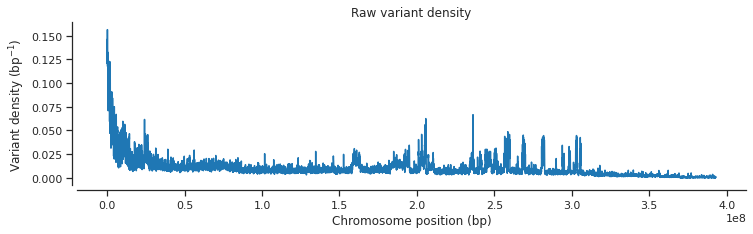

In [71]:
total_raw_dense = plot_windowed_variant_density(variants['POS'][:], window_size=50000, title='Raw variant density')

Depending on how the underlying VCF file is formatted, there may be more than one tag for each chromosome (e.g. chr1H_part1, chr1H_part2, etc). However, we can simply look for each unique chromosome tag here and plot each of them along the chromosomal position, thus avoiding the effects of improperly overlapping chromosomal regions. This can, however, take a while depending on the number of chromosomes and scaffolds found in the raw data.

Number of graphs to be generated:  15
(CHROM == "chr1H_part1")


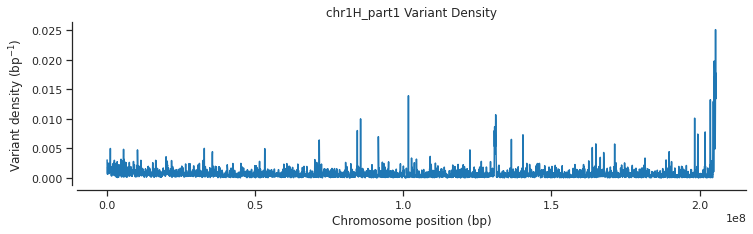

(CHROM == "chr1H_part2")


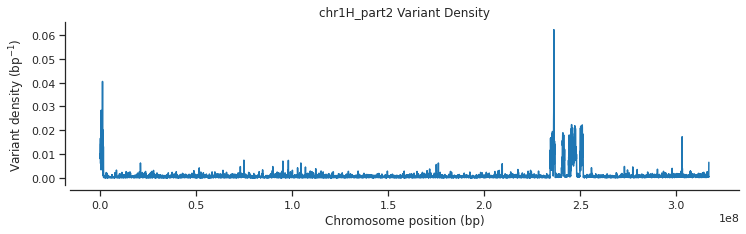

(CHROM == "chr2H_part1")


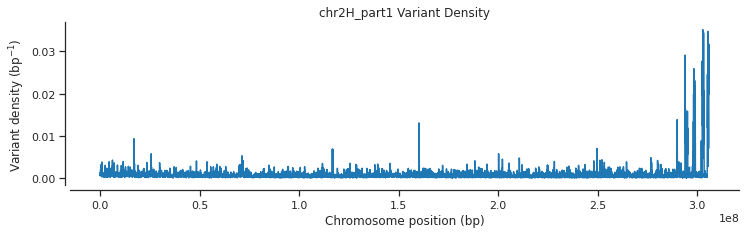

(CHROM == "chr2H_part2")


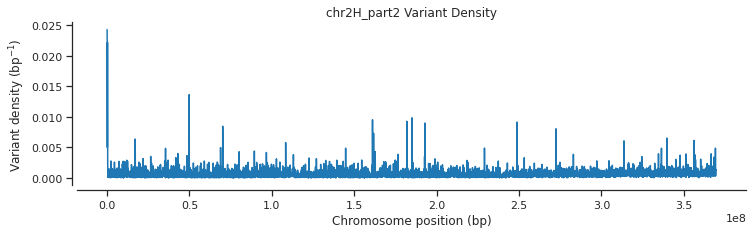

(CHROM == "chr3H_part1")


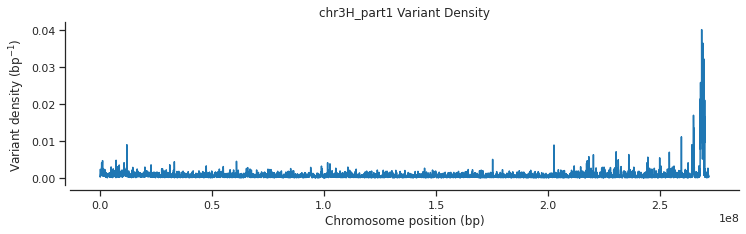

(CHROM == "chr3H_part2")


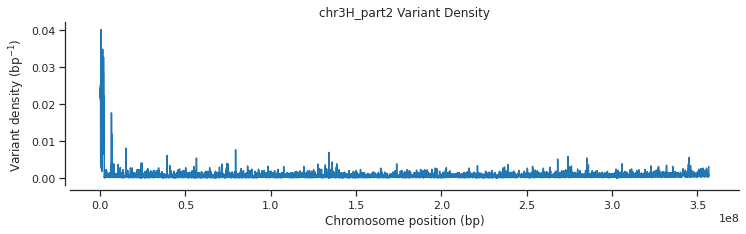

(CHROM == "chr4H_part1")


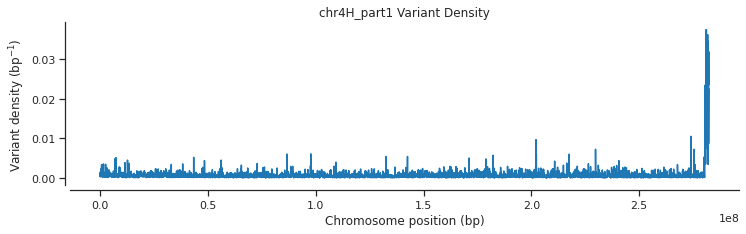

(CHROM == "chr4H_part2")


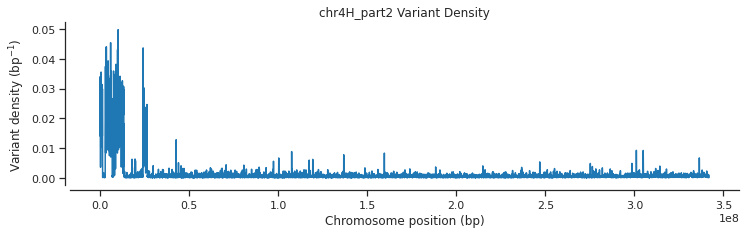

(CHROM == "chr5H_part1")


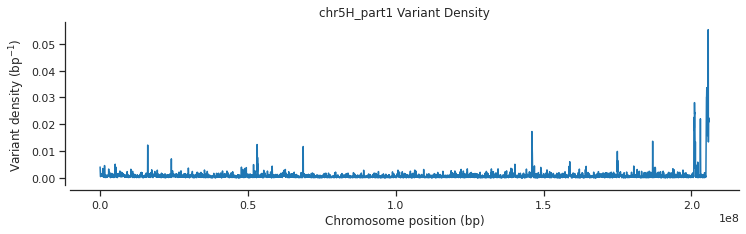

(CHROM == "chr5H_part2")


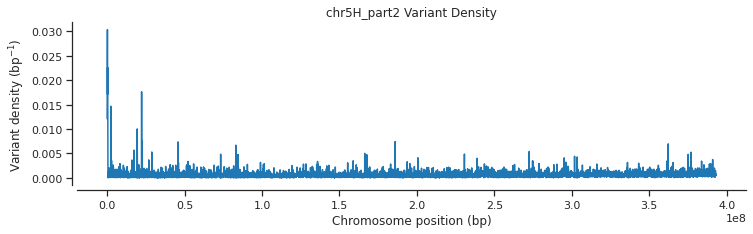

(CHROM == "chr6H_part1")


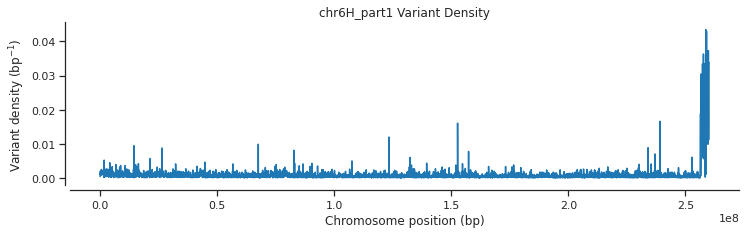

(CHROM == "chr6H_part2")


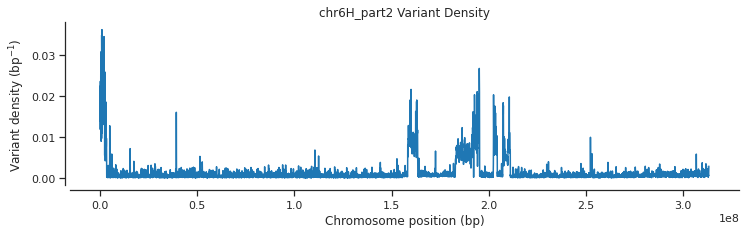

(CHROM == "chr7H_part1")


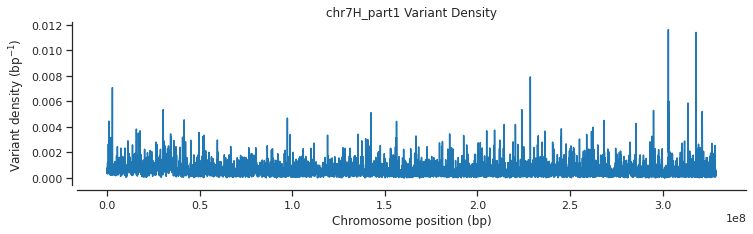

(CHROM == "chr7H_part2")


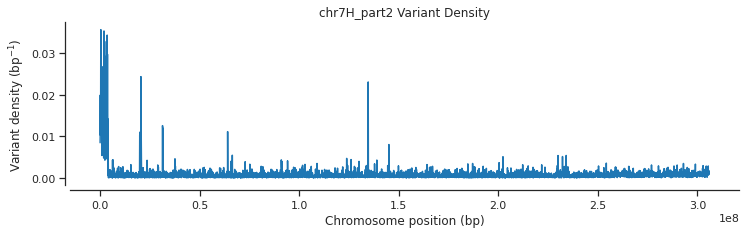

(CHROM == "chrUn")


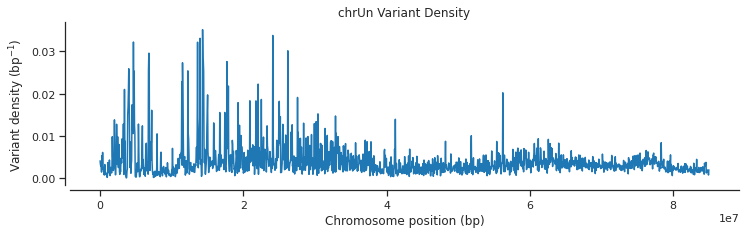

In [72]:
labs = np.unique(variants['CHROM'])
print('Number of graphs to be generated: ', len(labs))
for i in labs:
    print('(CHROM == "%s")' % i)
    variants_chrom = variants.query('(CHROM == "%s")' % i)
    # Here we create a local variable with the appropriate name and value pair
    name = ("%s_raw_dense" % i)
    locals()[name] = plot_windowed_variant_density(variants_chrom['POS'][:], window_size=50000, title=('%s Variant Density' % i))
    plt.show()


Then display the summary stats of the read depth across all samples (DP), and display a histogram of the number of variants with a given read depth (placed into 'bins' number of bins). We can also define a list of percent thresholds we'd want displayed within the plot. The read depth could be limited based upon the context and scale of the data, but we have specified defaults here. 

Given 3996208 samples, we have the following stats for DP:
Mean: 205.744132            
St. Deviation: 2073.710092
5th percentile: 2.000000
95th percentile: 537.000000



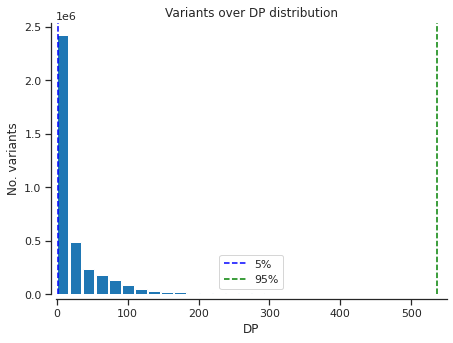

In [76]:
dp_set = variants['DP'][:]
dp_raw_plot = plot_variant_hist(dp_set, 'DP', neglim=-1, xlim=550, percents=[5,95])
summary_stats(dp_set, 'DP', 5, 95)

Same idea here but for QUAL scores into bins. QUAL scores (and the normalized version, QD) express the confidence that any variation exists at a given site. 

Given 3976755 samples, we have the following stats for QUAL:
Mean: 794.761597            
St. Deviation: 8136.425293
5th percentile: 0.000000
95th percentile: 1801.500000

50th percentile: 40.835601806640625


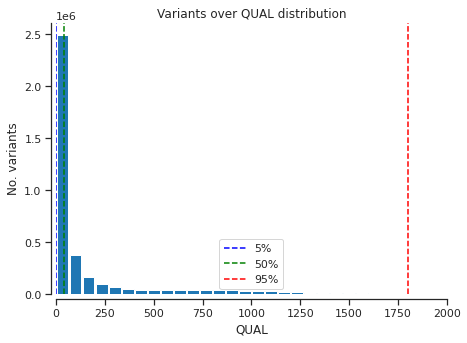

In [100]:
data_qual = variants['QUAL'][:]
# Drop nan values
data_qual_clean = data_qual[np.logical_not(np.isnan(data_qual))]

summary_stats(data_qual_clean, 'QUAL', 5, 95)
mid_thresh = np.percentile(data_qual_clean, 50)
print("50th percentile:", mid_thresh)
qual_raw_plot = plot_variant_hist(data_qual_clean, 'QUAL', xlim=2000, percents=[5,50,95])

Same idea here but for Quality by Depth. For GATK, this is generated by calling the QUAL score and dividing it by the allele depth (AD), thus normalizing by the depth of reads supporting said variant such that high coverage with weakly supported reads count for less than low coverage with strongly supported reads. 

**Caveat:** 10x Genomics VCF file doesn't have QD, so we can't plot this

Same idea here but for Genotyping Quality (GQ). GQ is calculated by GATK as the difference between the second lowest Phred-scaled likelihood of a genotype and the lowest likelihood, which is by convention 0 (further explanation of GATK conventions [here](https://software.broadinstitute.org/gatk/documentation/article?id=11075)). Furthermore, as it's calculated per sample, we can either flatten it to graph frequency across all samples or we can index so that we graph one sample's GQ (i.e. Sample A's GQ histogram across all variants, Sample B's histogram, etc.)

**Caveat:** 10x Genomics VCF file doesn't seem to have GQ

# Filtering and Analysis

Below we see an example filtering expression, along with both a query and compression example, in order to determine high vs low quality variants. The query method is less useful when using data outside of the variants chunked table (i.e. one might lose genotyping information), but is more concise when all of the necessary data is present. 

In [110]:
filter_expr_strong = '(DP >= 5) & (DP < 3000)'
filter_expr_weak = '(DP > 2) & (DP < 5000)'

# Here we filter using a simple query command, which is less extendible but more compact
variants_pass_strong = variants.query(filter_expr_strong)

# Here we filter using an evaluation of the above expression, then keep only
# those variants which satisfy said expression. This method can be extended
# to variant data stored elsewhere, assuming the ordering is the same. 
filter_weak = variants.eval(filter_expr_weak)
variants_pass_weak = variants.compress(filter_weak)

# How many variants remain within each group. 
print("Strongly filtered variants: %d" % len(variants_pass_strong))
print("Weakly filtered variants: %d" % len(variants_pass_weak))
print("Raw variants: %d" % len(variants))

Strongly filtered variants: 2992335
Weakly filtered variants: 3523961
Raw variants: 3996208


Now we can create the same plots as before, but with the newly filtered variants. We can also place these variants side-by-side using our methods from above. For example, if we plotted the variant density along the chromosome, we could get the following: 

We can also plot filtered datasets alone on a graph, such as below as a histogram, according to a desired attribute. 

Given 2992335 samples, we have the following stats for DP:
Mean: 107.468045            
St. Deviation: 315.185724
5th percentile: 5.000000
95th percentile: 561.000000



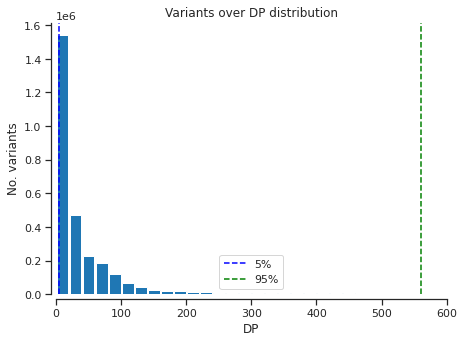

In [112]:
dp_set_s = variants_pass_strong['DP'][:]
summary_stats(dp_set_s, 'DP', 5, 95)
dp_strong_plot = plot_variant_hist(dp_set_s, 'DP', neglim=0, xlim=600, percents=[5,95])

We may also want to compare the attributes of differently filtered datasets, displaying the histogram bars either side by side for each bin...

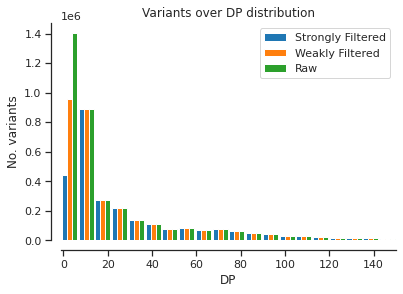

In [116]:
dp_set_w = variants_pass_weak['DP'][:]
dp_multi_plot = plot_multi_hist(np.array([dp_set_s, dp_set_w, dp_set]),'DP', neglim=-1,xlim=150, 
                lab=['Strongly Filtered', 'Weakly Filtered', 'Raw'], stacked=False)

...or alternatively we can also show the bars as overlapping, for a more direct and compact comparison. NOTE: In order for the plot to display properly, one must list the datasets and their corresponding labels from most general (or least filtered) to least general. Otherwise the less general datasets are hidden behind the more general one(s). 

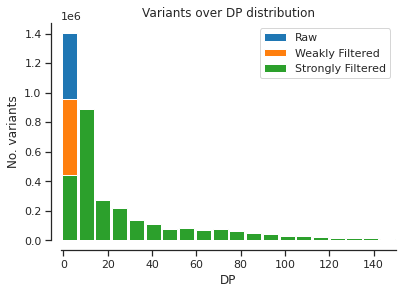

In [117]:
dp_multi_stacked = plot_multi_hist(np.array([dp_set, dp_set_w, dp_set_s]),'DP', neglim=-1,xlim=150, 
                lab=['Raw', 'Weakly Filtered', 'Strongly Filtered'], stacked=True)

Given 2992327 samples, we have the following stats for QUAL:
Mean: 449.605743            
St. Deviation: 1343.407715
5th percentile: 0.000000
95th percentile: 1853.260010



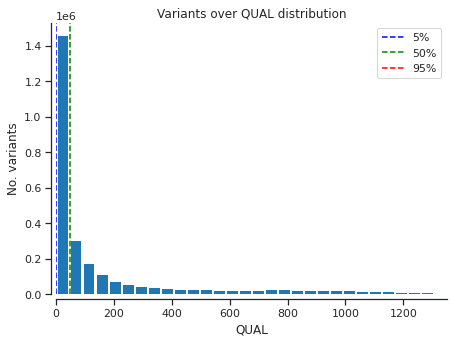

In [128]:
data_qual_s = variants_pass_strong['QUAL'][:]
# Remove nan values
data_qual_s_clean = data_qual_s[np.isfinite(data_qual_s)]
summary_stats(data_qual_s_clean, 'QUAL', 5, 95)

qual_strong_plot = plot_variant_hist(data_qual_s_clean, 'QUAL', xlim=1350, percents=[5,50,95])

# Ti/Tv Checking

Another helpful statistic to keep in mind for quality control is the ratio of transition to transversion mutations. Using pure chance we would expect relatively fewer transitions (a ratio of about 0.5), but the relevant mutation bias depends upon the organism being studied. Here we create an array of pairs with the reference and primary alternative alleles to help calculate the ratio. 

In [130]:
mutations = np.array(variants['REF'] + variants['ALT'][:,0]).astype(str)

Then we use several functions to check if they are transitions (Ti), what the relative Ti/Tv value of a set of variants is, and to plot the Ti/Tv values against variant attribute values. 

In [131]:
# If the reference and alternative alleles match the following patterns,
# then they are transitions. Otherwise they're transversions. 
def locate_transitions(x):
    x = np.asarray(x)
    return (x == 'AG') | (x == 'GA') | (x == 'CT') | (x == 'TC')

def ti_tv(x):
    if len(x) == 0:
        return np.nan
    is_ti = locate_transitions(x)
    n_ti = np.count_nonzero(is_ti)
    n_tv = np.count_nonzero(~is_ti)
    if n_tv > 0:
        return n_ti / n_tv
    else:
        return np.nan

# Here we can take every 'downsample' Ti/Tv value, in order to 
# lighten the computational load
def plot_ti_tv(f, downsample, bins):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    x = variants[f][:][::downsample]
    
    # plot an attribute's histogram
    ax.hist(x, edgecolor='black', bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')

    # plot Ti/Tv
    ax = ax.twinx()
    sns.despine(ax=ax, bottom=True, left=True, right=False, offset=10)
    values = mutations[::downsample]
    with np.errstate(over='ignore'):
        # binned_statistic generates an annoying overflow warning which we can ignore
        y1, _, _ = scipy.stats.binned_statistic(x, values, statistic=ti_tv, bins=bins)
    bx = (bins[1:] + bins[:-1]) / 2
    ax.plot(bx, y1, color='k')
    ax.set_ylabel('Ti/Tv')
    # ax.set_ylim(0.6, 1.3)

    ax.set_title('Variant %s and Ti/Tv' % f)
    
    return fig

In [132]:
# Ti/Tv over all variants
ti_tv(mutations)

0.6900208112100571

# Relating seperate tables' data

Here we setup data from a different part of our callset, namely the calldata and its genotype ('GT') column. The GT is represented by 21 samples' genotyping for the diploid data for barley, resulting in [numVariants] x [numSamples] x [ploidy] data shape. We can, however, compress the genotypes for desired variants using our filtering evaluation from the above section (referring to [here](#Filtering-and-Analysis)), thus allowing us to pare down the investigated space significantly.

In [135]:
calldata = callset['calldata']
genotypes = allel.GenotypeChunkedArray(calldata['GT'])

# Optionally pull in sample metadata as a table
# samples_fn = ''
# samples = pandas.DataFrame.from_csv(samples_fn, sep='\t')
# sample_selection = samples.[FilteringAttr].isin([Dict of desired values]).values
# samples_subset = samples[sample_selection]

# Filter our genotype list down using our previous filter
variant_selection = variants.eval(filter_expr_strong)[:]
genotypes_subset = genotypes.subset(variant_selection)

Computes the missingness and heterozygosity for each sample, using both the raw and filtered variants. 

In [136]:
n_variants = len(variants_pass_strong)
n_variants_raw = len(variants)

# Counts what percent of each set has missing genotypes
pc_missing_raw = genotypes.count_missing(axis=0)[:] * 100 / n_variants_raw
pc_missing = genotypes_subset.count_missing(axis=0)[:] * 100 / n_variants

# Counts what percent of each set is heterozygously genotyped
pc_het_raw = genotypes.count_het(axis=0)[:] * 100 / n_variants_raw
pc_het = genotypes_subset.count_het(axis=0)[:] * 100 / n_variants
print("Raw missingniess: %s\n\n" % pc_missing_raw, "Filtered missingness: %s\n\n" % pc_missing, 
      "Raw heterozygosity: %s\n\n" % pc_het_raw, "Filtered heterozygosity: %s\n\n" % pc_het)

Raw missingniess: [48.76375304 44.75300084 45.72189436]

 Filtered missingness: [43.3943392  39.42813889 40.82834977]

 Raw heterozygosity: [37.02922871 40.86964442 39.53452873]

 Filtered heterozygosity: [40.66306079 44.4555506  42.77836539]




Plots and compares statistics of each sample within either one set or multiple sets (such as after filtering variants). 

In [137]:
def plot_genotype_frequency(pc, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    left = np.arange(len(pc))
    palette = sns.color_palette()

    ax.bar(left, pc, color=palette[0])
    ax.set_xlim(0, len(pc))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)

    print(fig)
    return fig

In [138]:
def multi_genotype_frequency(pc, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    palette = sns.color_palette()
    left = np.arange(len(pc[0]))
    labels = []
    
#   ax.bar(left, pc)
    for i in range(len(pc)):
        ax.bar(left, pc[i], color=palette[i])
        if (i == 0):
            labels.append('Raw')
        else: 
            labels.append('Filtered subset %d' % i)
    ax.set_xlim(0, len(pc[0]))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)
    ax.legend(labels=labels)
    
    return fig

Here we plot the missingness data for the raw variants alongside the filtered variants. 

Figure(864x288)
Figure(864x288)


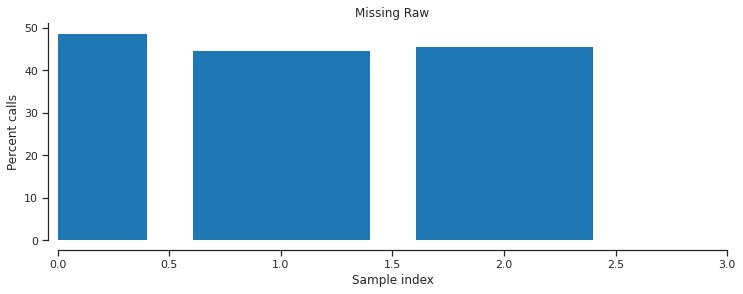

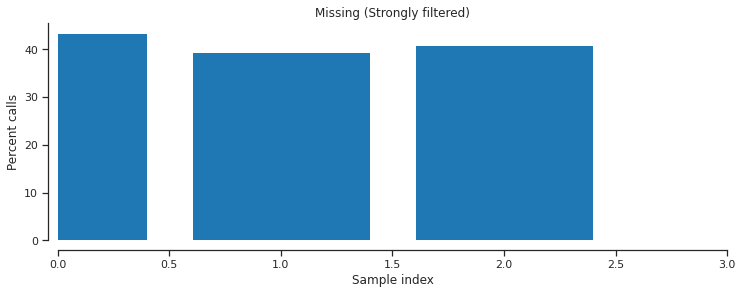

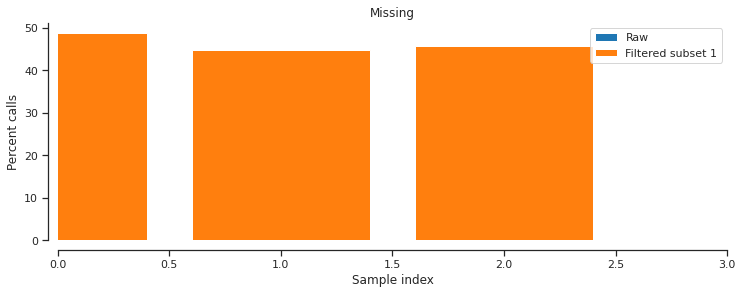

In [139]:
miss_raw_plot = plot_genotype_frequency(pc_missing_raw, 'Missing Raw')
miss_strong_plot = plot_genotype_frequency(pc_missing, 'Missing (Strongly filtered)')
miss_multi_plot = multi_genotype_frequency([pc_missing, pc_missing_raw], 'Missing')

Here we plot heterozygosity of samples from the raw variants

Figure(864x288)
Figure(864x288)


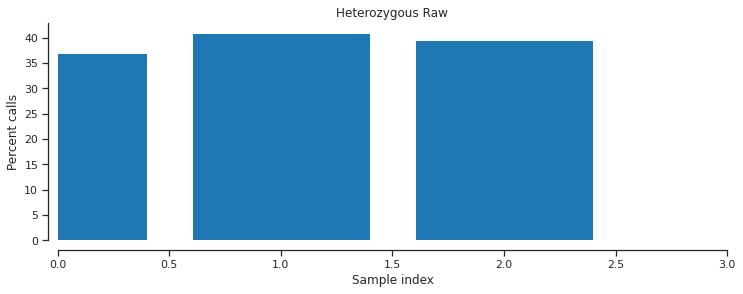

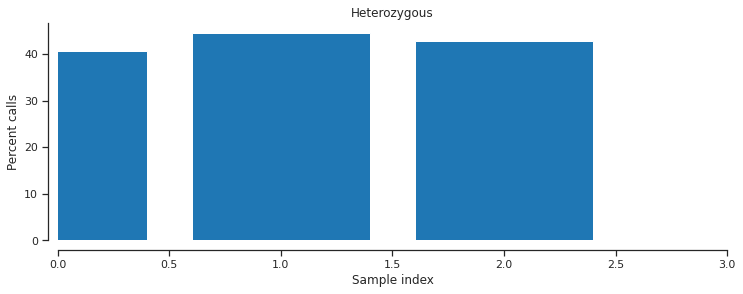

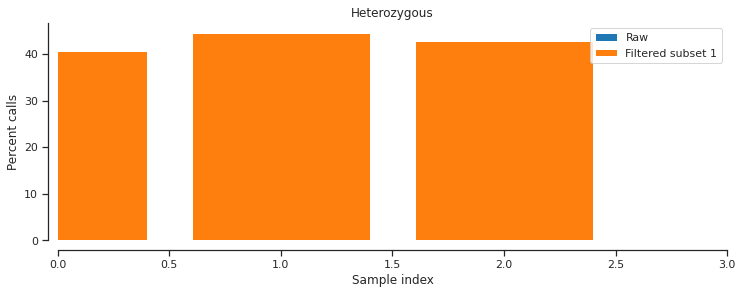

In [140]:
het_raw_plot = plot_genotype_frequency(pc_het_raw, 'Heterozygous Raw')
het_strong_plot = plot_genotype_frequency(pc_het, 'Heterozygous')
het_multi_plot = multi_genotype_frequency([pc_het_raw, pc_het], 'Heterozygous')

# Graphical Output

The final step here is to print each of the saved plots into a pdf file, as specified at the beginning with a PDF filepath.

In [144]:
pp = PdfPages(pdf_file)
for i in locals():
    if isinstance(eval(i), mpl.figure.Figure):
        print('Saving figure', i)
        pp.savefig(eval(i), bbox_inches='tight')
pp.close()
print('Done saving to PDF at', pdf_file)

Saving figure total_raw_dense
Saving figure chr1H_part1_raw_dense
Saving figure chr1H_part2_raw_dense
Saving figure chr2H_part1_raw_dense
Saving figure chr2H_part2_raw_dense
Saving figure chr3H_part1_raw_dense
Saving figure chr3H_part2_raw_dense
Saving figure chr4H_part1_raw_dense
Saving figure chr4H_part2_raw_dense
Saving figure chr5H_part1_raw_dense
Saving figure chr5H_part2_raw_dense
Saving figure chr6H_part1_raw_dense
Saving figure chr6H_part2_raw_dense
Saving figure chr7H_part1_raw_dense
Saving figure chr7H_part2_raw_dense
Saving figure chrUn_raw_dense
Saving figure dp_raw_plot
Saving figure qual_raw_plot
Saving figure dp_strong_plot
Saving figure dp_multi_plot
Saving figure dp_multi_stacked
Saving figure qual_strong_plot
Saving figure miss_raw_plot
Saving figure miss_strong_plot
Saving figure miss_multi_plot
Saving figure het_raw_plot
Saving figure het_strong_plot
Saving figure het_multi_plot
Done saving to PDF at /panfs/roc/groups/9/morrellp/liux1299/GitHub/Barley_Mutated/01_snp